In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns

In [2]:
# class defining Logistic Regression

class Logistic_Regression:
    def __init__(self, n_iters, alpha, lambda_=1):
        self.n_iters= n_iters
        self.alpha= alpha
        self.lambda_= lambda_
        self.W= None
        self.b= None
        
    def fit(self, X, y):
        m, n= X.shape                                           # m-> no. of training examples; n-> no. of features
        
        #initialising the weights and biases
        self.W= np.zeros(n)
        self.b= 0
        
        # applying gradient descent
        
        J_history=[]                            #stores the cost of each step
        w_history=[]                            #stores parameters at each step
        
        
        for i in range(self.n_iters):
            dJ_dw, dJ_db= self.parameters( X, y)
            self.W= self.W-self.alpha*dJ_dw
            self.b= self.b-self.alpha*dJ_db
            
            if i<100000:
                cost_n= self.compute_cost(X, y)
                J_history.append(cost_n)
                w_history.append(self.W)
                
            if(i%1000==0):                              #printing cost of every 1000th iteration
                print(J_history[-1])
                
        return (self.W, self.b)                         # the fit function will return the last parameters
                
                
    
                
    # function to compute cost for logistic regression    
                
    def compute_cost(self, X, y):
        cost=0
        m= X.shape[0]
        
        for i in range(m):
            loss= -y[i]*(np.log(self.sigmoid(X[i])))-(1-y[i])*(np.log(1-self.sigmoid(X[i])))
            cost+=loss
            
        reg=0
        for w in self.W:
            reg+=(w**2)
            
        reg=(self.lambda_)*(reg/(2*m))
        cost+=reg
            
        return cost
    
    
    # sigmoid function
    
    def sigmoid(self, X):
        z=np.dot(self.W,X)+self.b
        f_wb= 1/(1+np.exp(-z))
        return f_wb
    
    
    
    # function to compute the derivatives
    
    def parameters(self, X, y):
        dJ_dw=[0, 0]
        dJ_db=0
        m=X.shape[0]
        for i in range(m):
            dJ_dw_i=(self.sigmoid( X[i])- y[i])*X[i]
            dJ_db_i=(self.sigmoid( X[i])- y[i])
            
            dJ_dw+=dJ_dw_i
            dJ_db+=dJ_db_i
        
        dJ_dw=dJ_dw/m
        dJ_db=dJ_db/m
        
        return dJ_dw, dJ_db
    
    
    #prediction function
    
    def predict(self, X):
        Y_pred=[]
        for i in range(X.shape[0]):
            Y_pred.append(self.sigmoid(X[i]))
        return Y_pred

In [3]:
# scales the data according to z-score

class Standard_Scaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)                  #calculating the mean and standard deviation along columns
        self.std_ = np.std(X, axis=0)

    def transform(self, X):
        scaled_data = (X - self.mean_) / self.std_
        return scaled_data

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [4]:
#splitting the data into training and cross validation sets

def Splitter( X, test_size= 0.2, random_state= 42):
    np.random.seed(random_state)
    shuffled_indices= np.random.permutation(len(X))
    test_set_size= int(test_size* len(X))
    test_indices= shuffled_indices[:test_set_size]
    train_indices= shuffled_indices[test_set_size:]
        
    return train_indices, test_indices

In [5]:
def boxcox_gauss_transform(data):
    negative_values = np.any(data < 0)

    # handling negative values
    
    if (negative_values==1):
        # shift the data to make all values positive (add a constant)
        data += np.abs(data.min()) + 1e-10  # adding a very small value to avoid zero values

    # Apply Box-Cox transformation to both features
    transformed_data = np.zeros_like(data)
    for i in range(2):
        transformed_data[:, i], _ = boxcox(data[:, i])

    return transformed_data


In [6]:
#preparing the prediction finally, if yhat >=0.5, the prediction is 1 else it is 0

def final(y_pred):
    for i in range(len(y_pred)):
        if(y_pred[i]>=0.5):
            y_pred[i]=1
        else:
            y_pred[i]=0
    return y_pred

In [7]:
#the accuracy function -> percentage of datapoints accurately predicted
def accuracy(y, y_pred):
    count=0
    m=len(y_pred)
    for i in range(y.shape[0]):
        count+=(y_pred[i]==y[i])
        
    return (float(count/m))
        

In [8]:
#the confusion matrix function -> computes the confusion matrix, recall value, precision value and f1 score 
def confusion_matrix_fun(y, y_pred):
    confusion_matrix= np.zeros([2,2])
    for i in range(len(y)):
        if(y[i]==1 and y_pred[i]==1):
            confusion_matrix[0,0]+=1
        elif(y[i]==0 and y_pred[i]==1):
            confusion_matrix[0,1]+=1
        elif(y[i]==1 and y_pred[i]==0):
            confusion_matrix[1,0]+=1
        else:
            confusion_matrix[1,1]+=1
        
        recall= (confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1]))
        precision= (confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0]))
        f1_score= (2*precision*recall)/(precision+recall)

            
        
    return confusion_matrix, recall, precision, f1_score

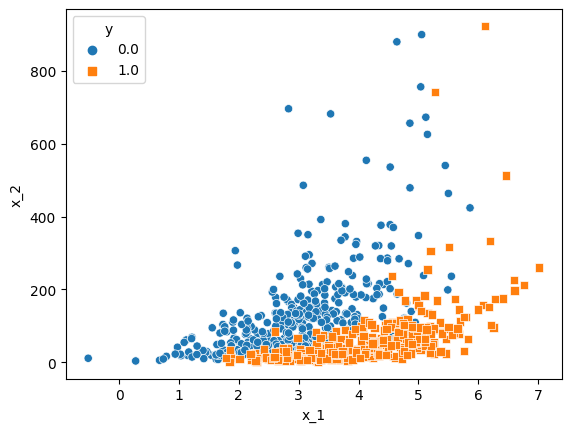

In [9]:
#plotting the data points -> red points denote label 1, while the blue ones denor
data=pd.read_csv('ds1_train.csv')
data_df=data.copy()
sns.scatterplot(data=data, x='x_1', y='x_2', hue='y', style='y', markers=['o', 's'])
data=np.array(data)

In [11]:
#dividing the dataset into training and cross validation sets
train_indices, test_indices= Splitter(data)
data_train= data[train_indices]
data_cv= data[test_indices]
X_train= data_train[:, :2]
y_train= data_train[:, 2:]
X_cv= data_cv[:, :2]
y_cv= data_cv[:, 2:]

data_train_df= pd.DataFrame(data_train, columns=['x_1', 'x_2', 'y'])

<Axes: xlabel='x_1', ylabel='x_2'>

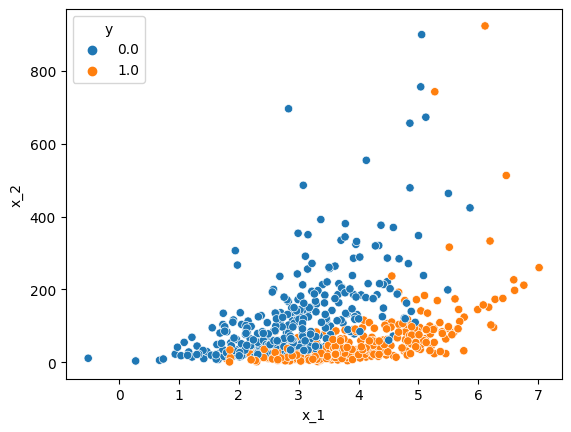

In [12]:
# visualising the training data
sns.scatterplot(data=data_train_df, x='x_1', y='x_2', hue='y', style='y', markers=['o', 'o'])

(array([  3.,  14.,  49.,  99., 122., 139., 114.,  71.,  21.,   8.]),
 array([-3.05569501, -2.46770535, -1.87971569, -1.29172604, -0.70373638,
        -0.11574673,  0.47224293,  1.06023259,  1.64822224,  2.2362119 ,
         2.82420155]),
 <BarContainer object of 10 artists>)

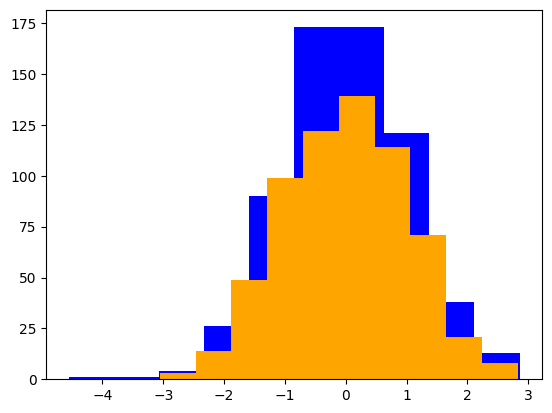

In [13]:
# applying scaling and boxcox transform to the training and cross validation sets

X_train= boxcox_gauss_transform(X_train)

scaler= Standard_Scaler()
X_train= scaler.fit_transform(X_train)


#plotting the histogram for training set
plt.hist(X_train[:, 0], color="blue")
plt.hist(X_train[:, 1], color="orange")

In [14]:
#training the model on the training set
model= Logistic_Regression(n_iters= 10000, alpha= 0.01, lambda_=1)
W_final, b_final= model.fit(X_train, y_train)
print(f'The final values of weights are: {W_final} and bias is: {b_final}')

[442.95652109]
[220.0145344]
[181.89711963]
[167.13018225]
[159.55815489]
[155.09244882]
[152.22832815]
[150.28599319]
[148.91542477]
[147.91923788]
The final values of weights are: [ 3.2071509  -2.97880933] and bias is: [-0.1118301]


In [14]:
# accuracy of predictions over the training set
y_pred_train= model.predict(X_train)
y_pred_train= final(y_pred_train)
print(("%0.4f" %accuracy(y_train, y_pred_train)))

0.9078


In [15]:
# here the cross-validation set is splitted into two datasets 5 times and model is trained on the larger set while
# prediction is made in the smaller set. each time the datasets are different as a different random state is seeded each time
p=55
accuracy_list=[]
for i in range(5):
    train, test= Splitter(data_cv, random_state=p)
    data_= data_cv[train]
    X_= data_[:, :2]
    y_= data_[:, 2:]
    _data= data_cv[test]
    _X= _data[:, :2]
    _y= _data[:, 2:]
    X_= boxcox_gauss_transform(X_)
    X_= scaler.fit_transform(X_)
    _X= boxcox_gauss_transform(_X)
    _X= scaler.fit_transform(_X)
    model_new= Logistic_Regression(n_iters= 10000, alpha= 0.01, lambda_=1)
    model_new.fit(X_, y_)
    y_pred_= model_new.predict(_X)
    y_pred_= final(y_pred_)
    accuracy_list.append(accuracy(_y, y_pred_))
    p+=20

[88.56582156]
[38.87796079]
[30.51524581]
[27.03017063]
[25.10201991]
[23.87663244]
[23.03081155]
[22.41403683]
[21.94632878]
[21.58110908]
[88.58386744]
[42.44687604]
[34.54303365]
[31.39882176]
[29.74579252]
[28.74754585]
[28.09244358]
[27.63802631]
[27.31010298]
[27.06636165]
[88.56487785]
[40.25080733]
[32.71842618]
[29.75350211]
[28.20117499]
[27.26694796]
[26.65608576]
[26.23405648]
[25.93084532]
[25.70654394]
[88.55619298]
[37.77463204]
[29.78007564]
[26.58752422]
[24.89135934]
[23.85504681]
[23.16679886]
[22.68361938]
[22.33070991]
[22.06520085]
[88.56881005]
[40.69964442]
[33.16856908]
[30.20769832]
[28.65691354]
[27.72242994]
[27.11030668]
[26.68650861]
[26.38130956]
[26.15496652]


In [16]:
print(accuracy_list)

[0.90625, 0.9375, 0.96875, 0.8125, 0.96875]


In [17]:
data_test= np.array(pd.read_csv('ds1_test.csv'))
X_test= data_test[:, :2]
y_test= data_test[:, 2:]
X_test= boxcox_gauss_transform(X_test)

X_test= scaler.fit_transform(X_test)

In [18]:
y_pred_test=final(model.predict(X_test))
print(accuracy(y_test, y_pred_test))

0.92


In [19]:
splitted_test_1_idx, splitted_test_2_idx= Splitter(data_test)
splitted_test_1= data_test[splitted_test_1_idx]
splitted_test_2= data_test[splitted_test_2_idx]
X_1= splitted_test_1[:, :2]
y_1= splitted_test_1[:, 2:]
X_2= splitted_test_2[:, :2]
y_2= splitted_test_2[:, 2:]

X_1= boxcox_gauss_transform(X_1)
X_1= scaler.fit_transform(X_1)

X_2= boxcox_gauss_transform(X_2)
X_2= scaler.fit_transform(X_2)

In [20]:
n_iters_list=[1000, 10000]
alphas= [ 0.01, 0.001]
lambdas=[0.1 ,1.0,10.0]

In [21]:
accuracy_list=[]
hyper_param=[]
f1_score_list=[]
for k in (lambdas):
    for i in n_iters_list:
        for j in alphas:
            model_=Logistic_Regression(n_iters= i, alpha= j, lambda_= k)
            model_.fit(X_1, y_1)
            y_pred= model_.predict(X_2)
            y_pred=final(y_pred)
            _accuracy= accuracy(y_2, y_pred)
            _,_,_,f1_score= confusion_matrix_fun(y_2, y_pred)
            accuracy_list.append(_accuracy)
            hyper_param.append([i, j, k])
            f1_score_list.append(f1_score)

[55.37055445]
[55.44364648]
[55.37055445]
[28.22156185]
[23.81889272]
[22.16616322]
[21.34278351]
[20.87373027]
[20.5858841]
[20.40133485]
[20.2800342]
[20.19943178]
[55.44364648]
[48.4985744]
[43.42767565]
[39.65192288]
[36.77411662]
[34.529332]
[32.74066464]
[31.28822591]
[30.08910365]
[29.08469971]
[55.370559]
[55.44364653]
[55.370559]
[29.59488579]
[26.61285747]
[26.10926185]
[26.23984476]
[26.58167823]
[26.99483129]
[27.4237137]
[27.84411786]
[28.24523949]
[55.44364653]
[48.53744735]
[43.56138507]
[39.91330505]
[37.1818502]
[35.09351541]
[33.46617226]
[32.17672283]
[31.14026903]
[30.29698187]
[55.37060444]
[55.44364698]
[55.37060444]
[43.32812526]
[54.55250504]
[65.54024811]
[75.21045726]
[83.6611578]
[91.08430322]
[97.64750226]
[103.48495453]
[108.70331653]
[55.44364698]
[48.92617687]
[44.89847926]
[42.52712678]
[41.25918607]
[40.73534953]
[40.72124845]
[41.06169209]
[41.65192279]
[42.41980346]


In [22]:
print(accuracy_list)

[0.9, 0.85, 0.95, 0.9, 0.9, 0.85, 0.95, 0.9, 0.9, 0.85, 0.95, 0.9]


In [23]:
print(f1_score_list)

[0.888888888888889, 0.8421052631578948, 0.9411764705882353, 0.888888888888889, 0.888888888888889, 0.8421052631578948, 0.9411764705882353, 0.888888888888889, 0.888888888888889, 0.8421052631578948, 0.9411764705882353, 0.888888888888889]


In [24]:
print(hyper_param)

[[1000, 0.01, 0.1], [1000, 0.001, 0.1], [10000, 0.01, 0.1], [10000, 0.001, 0.1], [1000, 0.01, 1.0], [1000, 0.001, 1.0], [10000, 0.01, 1.0], [10000, 0.001, 1.0], [1000, 0.01, 10.0], [1000, 0.001, 10.0], [10000, 0.01, 10.0], [10000, 0.001, 10.0]]


In [25]:
print(f"The best hyperparameters according to accuracy and f1_score are: {hyper_param[2]}, {hyper_param[6]} and {hyper_param[10]}")

The best hyperparameters according to accuracy and f1_score are: [10000, 0.01, 0.1], [10000, 0.01, 1.0] and [10000, 0.01, 10.0]


In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
log_reg= LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_train_sk= log_reg.predict(X_train)
print(accuracy(y_train, y_pred_train_sk))

0.909375


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
y_pred_test_sk= log_reg.predict(X_test)
print(accuracy(y_test, y_pred_test_sk))

0.93


# The accuracy of the developed model on the test set is 0.92 while that of sklearn model is 0.93

In [29]:
# training the model on the 2nd dataset

In [16]:
data_2= np.array(pd.read_csv('ds2_train.csv'))
train_2, test_2= Splitter(data_2)
data_train_2= data_2[train_2]
data_cv_2= data_2[test_2]

X_train_2= data_train_2[:, :2]
X_cv_2= data_cv_2[:, :2]
data
y_train_2= data_train_2[:, 2:]
y_cv_2= data_cv_2[:, 2:]

X_train_2.dtype

dtype('float64')

In [17]:
# boxcox transformation and scaling the features
X_train_2= boxcox_gauss_transform(X_train_2)
X_train_2= scaler.fit_transform(X_train_2)
model_2= Logistic_Regression(n_iters= 10000, alpha= 0.01, lambda_=1)
model_2.fit(X_train_2, y_train_2)
y_train_pred_2= model_2.predict(X_train_2)

[442.92454963]
[211.28330359]
[172.26597401]
[157.12878413]
[149.32527957]
[144.69091812]
[141.69516213]
[139.64627551]
[138.18756066]
[137.11740828]


In [18]:
y_train_pred_2= final(y_train_pred_2)
print(accuracy(y_train_2, y_train_pred_2))

0.9078125


In [19]:
X_cv_2= boxcox_gauss_transform(X_cv_2)
X_cv_2= scaler.fit_transform(X_cv_2)

In [20]:
y_cv_pred_2= final(model_2.predict(X_cv_2))
print(accuracy(y_cv_2, y_cv_pred_2))

0.95625


In [21]:
data_test_2= np.array(pd.read_csv('ds2_test.csv'))
X_test_2= data_test_2[:, :2]
y_test_2= data_test_2[:, 2:]

#boxcox transformation and scaling
X_test_2= boxcox_gauss_transform(X_test_2)
X_test_2= scaler.fit_transform(X_test_2)

In [22]:
n_iters_list=[1000, 10000]
alphas= [ 0.01, 0.001]
lambdas=[0.1 ,1.0,10.0]

In [23]:
accuracy_list_2=[]
f1_score_list_2=[]
for k in lambdas:
    for i in alphas:
        for j in n_iters_list:
            X_train_2= data_train_2[:, :2]
            y_train_2= data_train_2[:, 2:]
            #boxcox transformation and scaling
            X_train_2= boxcox_gauss_transform(X_train_2)
            X_train_2= scaler.fit_transform(X_train_2)
            model_new_2= Logistic_Regression(n_iters=j, alpha=i, lambda_=k)
            model_new_2.fit(X_train_2, y_train_2)
            y_pred_= final(model_new_2.predict(X_test_2))
            accuracy_list_2.append(accuracy(y_test_2, y_pred_))
            _,_,_,f1_score_2= confusion_matrix_fun(y_test_2, y_pred_)
            f1_score_list_2.append(f1_score_2)

[442.92454962]


/var/folders/rz/4wkyghgs70q02_v9zvprnnhw0000gn/T/ipykernel_672/1691398175.py:14: RuntimeWarning: invalid value encountered in scalar divide
  recall= (confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1]))
/var/folders/rz/4wkyghgs70q02_v9zvprnnhw0000gn/T/ipykernel_672/1691398175.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision= (confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0]))


[442.92454962]
[211.28101881]
[172.26131872]
[157.12221474]
[149.31712894]
[144.68143113]
[141.68452641]
[139.6346398]
[138.17504599]
[137.10411513]
[443.54518049]
[443.54518049]
[384.58493301]
[341.53921111]
[309.45237407]
[284.93843023]
[265.75418913]
[250.40999819]
[237.89980404]
[227.52898425]
[218.80674201]
[442.92454963]
[442.92454963]
[211.28330359]
[172.26597401]
[157.12878413]
[149.32527957]
[144.69091812]
[141.69516213]
[139.64627551]
[138.18756066]
[137.11740828]
[443.54518049]
[443.54518049]
[384.58499779]
[341.53943369]
[309.45280886]
[284.93910819]
[265.75512708]
[250.41120435]
[237.90128133]
[227.53073232]
[218.80875842]
[442.9245497]
[442.9245497]
[211.30615145]
[172.31252695]
[157.19447799]
[149.40678584]
[144.78578805]
[141.80151932]
[139.76263261]
[138.31270742]
[137.25033973]
[443.54518049]
[443.54518049]
[384.5856456]
[341.54165948]
[309.45715675]
[284.94588778]
[265.76450656]
[250.42326591]
[237.91605424]
[227.54821294]
[218.82892253]


In [24]:
print(accuracy_list_2)

[0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93]


In [25]:
print(f1_score_list_2)

[0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307]


In [26]:
# sklearn on 2nd dataset

In [31]:
X_train_2= data_train_2[:, :2]
y_train_2= data_train_2[:, 2:]

In [33]:
log_reg_2= LogisticRegression()
log_reg_2.fit(X_train_2, y_train_2)
y_pred_train_sk_2= log_reg.predict(X_train_2)
print(accuracy(y_train_2, y_pred_train_sk_2))

0.9109375


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
y_pred_test_sk_2= log_reg.predict(X_test_2)
print(accuracy(y_test_2, y_pred_test_sk_2))

0.91
